In [41]:
# %%capture
# %pip install carbon-simulator
# %pip install ipywidgets

In [42]:
from carbon.helpers.stdimports import *
from carbon.helpers import j, strategy, pdread, pdcols, fsave, listdir, Params, PathInterpolation as PI
from carbon.helpers import require_version
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
try:
    from simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS, COLORS, __VERSION__ as simversion
    from carbon.helpers.simulation import __VERSION__ as csimversion
    print(f"Using local copy of the simulation library [v{simversion}; Carbon: v{csimversion}]")
except:
    from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS, COLORS, __VERSION__ as simversion
    print(f"Using simulation library in Carbon [v{simversion}]")
import pickle
import datetime 

plt.rcParams['figure.figsize'] = [12,6]
plt_style('seaborn-v0_8-dark', 'seaborn-dark')
print_version(require="2.3")

Using local copy of the simulation library [v3.1-local; Carbon: v3.0]
Carbon v2.3 (29/Jan/2022)


# Carbon Simulation - Demo 7-4 
**Latest** notebook on [Binder][latest_nb] and on [github][latest_gh]

Use **Run -- Run All Cells** in the menu above to run the notebook, then adjust the simulation parameters using the widgets provided. 

Further resources are (1) the github repo [github:carbon-simulator-binder][repob] associated with this binder, (2) the main simulator repo [github:carbon-simulator][repo], (3) the carbon package [pypi:carbon-simulator][simpypi] and finally (4) the ["Carbon Simulator" presentation][presn]

[presn]:https://github.com/bancorprotocol/carbon-simulator/blob/beta/resources/notes/202301%20Simulating%20Carbon.pdf
[simpypi]:https://pypi.org/project/carbon-simulator/
[repo]:https://github.com/bancorprotocol/carbon-simulator
[repob]:https://github.com/bancorprotocol/carbon-simulator-binder
[frozen]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230128
[frozen_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230128?labpath=Frozen%2FDemo7-4%2FDemo7-4.ipynb
[frozen_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/frozen_20230128/Frozen/Demo7-4/Demo7-4.ipynb
[latest_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/latest_7_4?labpath=Frozen%2FDemo7-4%2FDemo7-4.ipynb
[latest_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/latest_7_4/Frozen/Demo7-4/Demo7-4.ipynb

## Setup

### Generated output

If `OUTPATH` is `None`, output will not be saved, otherwise it will be saved to the indicated directory (use `"."` for current)

In [43]:
OUTPATH = "."
try:
    output_w()
except:
    output_w = CheckboxManager.from_idvdct(
        {f"Save output to target directory": True,
         f"Show target directory listing": True,
         f"Generate docx & zip from charts": True,
         f"Clear files before each run": False,
        })
    output_w()

In [44]:
fname = lambda data, col: f"{datetime.datetime.now().strftime('%m%d-%H%M%S')}-{data}-{col.replace('/', '')}.png"
fname("DATA", "COL")

'0129-214105-DATA-COL.png'

### Source data selection

Filename determines **collection**, eg `BTC-COINS`is a collection of coins with prices expressted in BTC, and `RAN-050-00` is sig=50% vol and mu=0% drift. If you change the top dropdown, use **Run All** to update the bottom dropdown allowing you to choose the **pair**. Check `invert` if you want inverse quotation, and choose `hf interpolate` and if you want to augment the path with random high frequency data of the same overall volatility.

In [45]:
DATAPATH = "../data"
try:
    datafn_w()
except:
    datafn_w = DropdownManager(listdir(DATAPATH, ".pickle"), defaultval="COINS-ETH")
    datafn_w()

Dropdown(index=2, options=(('COINS-BTC', 'COINS-BTC'), ('COINS-CROSS', 'COINS-CROSS'), ('COINS-ETH', 'COINS-ET…

In [46]:
cols = tuple(pdcols(j(DATAPATH, f"{datafn_w.value}.pickle")))
try:
    assert datafn_w.value == old_datafn_w_value
    datacols_w()
except:
    old_datafn_w_value = datafn_w.value
    datacols_w = DropdownManager(cols, defaultval="BTC/ETH" if datafn_w.value=="COINS-ETH" else None)
    datacols_w()

Dropdown(index=2, options=(('AVAX/ETH', 'AVAX/ETH'), ('OKB/ETH', 'OKB/ETH'), ('BTC/ETH', 'BTC/ETH'), ('XRP/ETH…

In [47]:
try:
    pathops_w()
except:
    pathops_w = CheckboxManager(["invert", "hf interpolate"], values=[0,0])
    pathops_w()

In [48]:
PIPERIOD = PI.hours(1)  # the granulariy of the path if "hf interpolate" was checked
PIFACTOR = 1            # the scaling factor applied to the macroscopic vol of the path

### Strategy selection

In [49]:
strats = {
     "slider":     None, # driven by sliders below
     "wide1":      [strategy.from_mgw(m=100, g=0.1, w=0.4)],
     "wide2":      [strategy.from_mgw(m=100, g=0.4, w=0.1)],
     "mid1":       [strategy.from_mgw(m=100, g=0.2, w=0.1)],
     "mid2":       [strategy.from_mgw(m=100, g=0.3, w=0.01)],
     "narrow":     [strategy.from_mgw(m=100, g=0.05, w=0.01)],
     "uni v3":     [strategy.from_u3(p_lo=10, p_hi=14, start_below=False, fee_pc=0.05, tvl_csh=1000)],
}
try:
    strats_w()
except:
    #strats_w = CheckboxManager(strats.keys(), values=True)
    strats_w = CheckboxManager(strats.keys(), values=[1]*(len(strats)-1)+[0])
    strats_w()

### Chart elements and look

In [50]:
colors = {
    'bidFill': 'lightgreen',
    'askFill': 'lightcoral',
    'bid': 'green',
    'ask': 'red',
    'price': 'darkorange',
    'hodl': 'cyan',
    'value': ('blue', 'silver'),
    'valuehf': ('royalblue', 'silver')
}

In [51]:
sim_defaults = {
    'plotPrice': True,
    'plotValueCsh': True,
    'plotValueRsk': False,
    'plotValueTotal': True,
    'plotValueGrey': False,
    'plotValueHODL': False,
    'plotRanges': True,
    'plotMargP': True,
    'plotBid': True,
    'plotAsk': True,
    "plotDark": False,
    'plotInterpolated': True
}
plt_styles = (('seaborn-v0_8-dark', 'seaborn-dark'), ('dark_background',)*2)

In [52]:
try: 
    params_w()
except:
    params_w = CheckboxManager.from_idvdct(sim_defaults)
    params_w()

### Time period

this is the time period that is plotted; periods and start dates are quoted as percentage total time; the window is cut at the left, eg start=0.9 and length=0.5 shows 0.9...1.0. Before the sliders are applied, everything before `PATH_MIN_DATE` is discarded. 

In [54]:
PATH_MIN_DATE = "2021-01-01" # 2021-01-01 for ETH/BTC and Uni v3 range
try:
    segment_w(vertical=True)
except:
    segment_w = PcSliderManager(["Start date %", "Length %"], values=[0,1])
    segment_w(vertical=True)

### Strategy fine tuning

 The parameter `csh` is the initial cash percentage of the portfolio (100%=all cash), and it total cash value is `TVL`. The slider `shift` allows shifting _all_ strategies up or down (eg, 5 is 5% up)

In [55]:
TVL = 1000
try:
    stratall_w(vertical=True)
except:
    stratall_w = PcSliderManager(["csh", "shift"], values=[0.5, 0], range=[(0,1), (-0.5,0.5)])
    stratall_w(vertical=True)

### The `slider` strategy

This is the strategy called `slider`. Here `m` is the mid price of the range (adjust `S0`, `SMIN`, `SMAX` to change), `g%` is the gap between the ranges in percent, and `w%` is the width of the ranges in percent. The parameter `u%` is the range utilisation rate, where `u=0%` means the range is full, and `u~100%` means that it is almost empty.

In [56]:
if require_version("2.3.1", raiseonfail=False):
    try:
        strat1_w(vertical=True)
    except:
        S0, SMIN, SMAX = 100, 50, 200
        strat1_w = PcSliderManager(["m", "g%", "w%", "ubid%", "uask%"], 
                            values=[S0/100, 0.1, 0.25, 0, 0], 
                            range=[(SMIN/100,SMAX/100),(0,0.50),(0,0.50),(0,1),(0,1)])
        strat1_w(vertical=True)
else:
    try:
        strat1_w(vertical=True)
    except:
        S0, SMIN, SMAX = 100, 50, 200
        strat1_w = PcSliderManager(["m", "g%", "w%", "u%"], 
                            values=[S0/100, 0.1, 0.25, 0], 
                            range=[(SMIN/100,SMAX/100),(0,0.50),(0,0.50),(0,1)])
        strat1_w(vertical=True)

## Simulation

In [57]:
if output_w.values[3]:
    !rm {OUTPATH}/*.png
    !rm {OUTPATH}/*.data
    !rm {OUTPATH}/_CHARTS.*

### Charts

TVL0=1000.0, TVL1_hf=1429.9 (43.0%) TVL1_lf=1429.9 (43.0%)


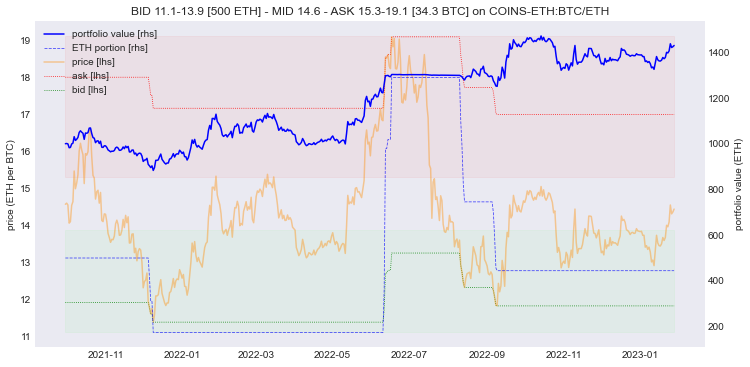

TVL0=1000.0, TVL1_hf=1226.0 (22.6%) TVL1_lf=1226.0 (22.6%)


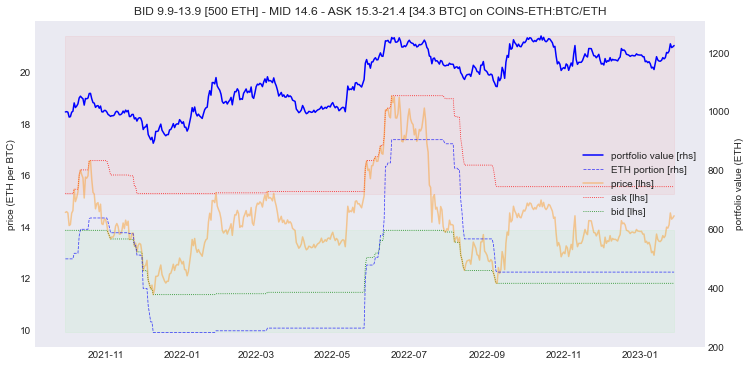

TVL0=1000.0, TVL1_hf=1372.5 (37.2%) TVL1_lf=1372.5 (37.2%)


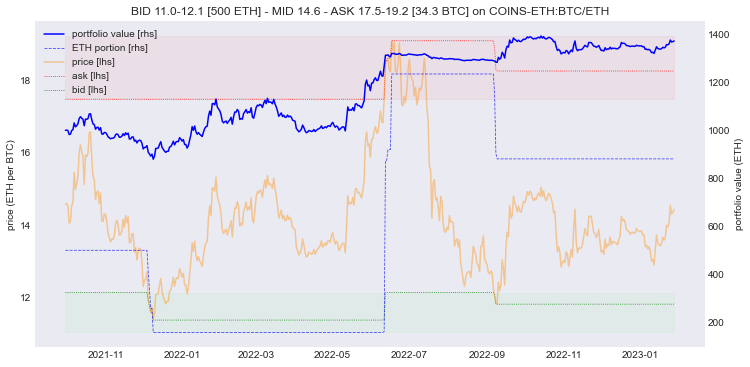

TVL0=1000.0, TVL1_hf=1489.8 (49.0%) TVL1_lf=1489.8 (49.0%)


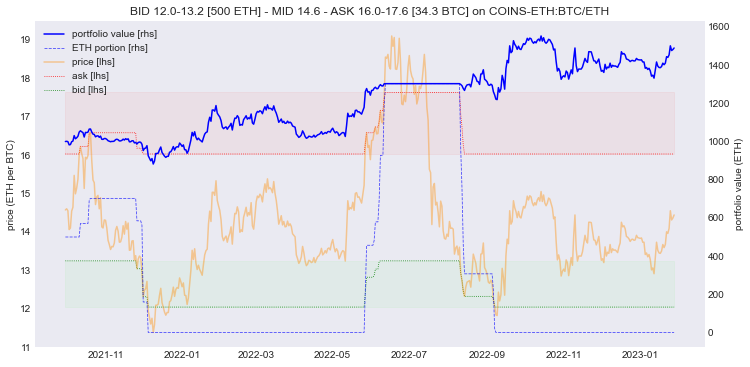

TVL0=1000.0, TVL1_hf=1426.9 (42.7%) TVL1_lf=1426.9 (42.7%)


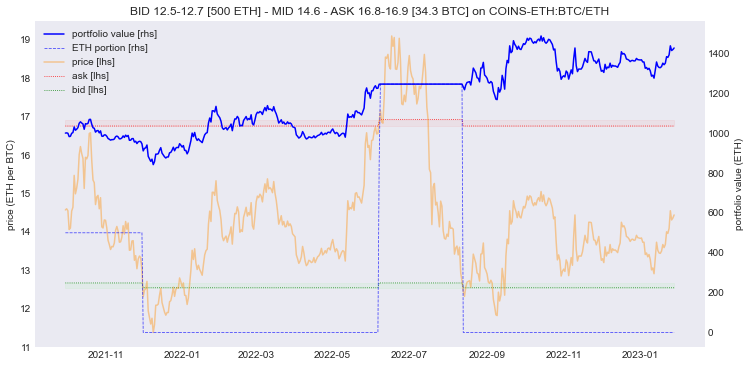

TVL0=1000.0, TVL1_hf=1350.0 (35.0%) TVL1_lf=1350.0 (35.0%)


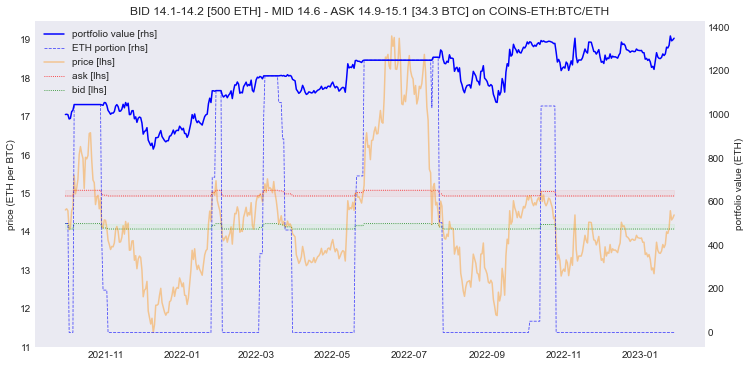

In [58]:
_ = plt_style(*plt_styles[1]) if params_w.values_dct["plotDark"] else plt_style(*plt_styles[0])
DATAID, DATAFN = datafn_w.value, j(DATAPATH, f"{datafn_w.value}.pickle") 
STARTPC, LENPC, SV, COLNM = segment_w.values[0], segment_w.values[1], strat1_w.values, datacols_w.value
path0, pair = pdread(DATAFN, COLNM, from_pc=STARTPC, period_pc=LENPC, min_dt=PATH_MIN_DATE, invert=pathops_w.values[0], tkns=True)
path = PI.interpolate(path0, PIPERIOD, sigfctr=PIFACTOR, enable=pathops_w.values[1])
try:
    strats["slider"] = [strategy.from_mgw(m=100*SV[0], g=SV[1], w=SV[2], u=(SV[4], SV[3]))]
except:
    strats["slider"] = [strategy.from_mgw(m=100*SV[0], g=SV[1], w=SV[2], u=SV[3])]
for ix, stratid in enumerate(strats_w.checked):
    strat = [s.set_tvl(spot=path0[0], cashpc=stratall_w.values[0], tvl=TVL) for s in strats[stratid]]
    simresults  = run_sim(strat, path, shift=stratall_w.values[1])
    simresults0 = run_sim(strat, path0, shift=stratall_w.values[1]) if not path is path0 else simresults
    v0, v1, v1a = simresults.value_r[0], simresults.value_r[-1], simresults0.value_r[-1]
    print(f"TVL0={v0:.1f}, TVL1_hf={v1:.1f} ({v1/v0*100-100:.1f}%) TVL1_lf={v1a:.1f} ({v1a/v0*100-100:.1f}%)")
    plot_sim(simresults, simresults0, f"{DATAID}:{COLNM}", Params(**params_w.values_dct), pair=pair, colors=colors)
    if isinstance(OUTPATH, str):
        plt.savefig(j(OUTPATH, fname(DATAID, COLNM)))
        fsave(pickle.dumps((simresults, simresults0)), f"{fname(DATAID, COLNM)}.data", OUTPATH, binary=True)
    plt.show()

### Directory listing

Provide the corresponding box above (_"Show target directory listing"_) is checked, this will create a list of all `png` files generated throughout your analysis. Those files will only be generated is the box _"Save output to target directory"_ box is checked. The target directory is preset to the directory of this notebook, but you can change this in the code above. Keep in minds that if you run this analysis **on Binder, you have to download all files you want to keep before the server is destroyed.**

In [59]:
if OUTPATH and output_w.values[1]:
    print("Listing OUTPATH [uncheck box at top to disable]")
    print ("\n".join([fn[:-4] for fn in os.listdir(OUTPATH) if fn[-4:]==".png"]))

Listing OUTPATH [uncheck box at top to disable]
0129-213935-COINS-ETH-BTCETH
0129-214050-COINS-ETH-BTCETH
0129-213927-COINS-ETH-BTCETH
0129-214051-COINS-ETH-BTCETH
0129-214106-COINS-ETH-BTCETH
0129-213934-COINS-ETH-BTCETH
0129-213926-COINS-ETH-BTCETH
0129-214039-COINS-ETH-BTCETH
0129-214040-COINS-ETH-BTCETH
0129-213925-COINS-ETH-BTCETH
0129-214105-COINS-ETH-BTCETH
0129-213341-COINS-ETH-BTCETH
0129-213340-COINS-ETH-BTCETH


Provide the corresponding box above (_"Generate docx & zip from charts"_) is checked, this will create a Word `docx` file embedding all the `png` files

### Create zip and docx

In [60]:
if OUTPATH and output_w.values[2]:
    print("Creating consolidated docx and zip from charts and data [uncheck box at top to disable]")
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in [fn for fn in os.listdir(OUTPATH) if fn[-4:]==".png"])
    !zip _CHARTS.zip -qq *.png
    !zip _DATA.zip -qq *.data 
    fsave(markdown, "_CHARTS.md", OUTPATH, quiet=True)
    !pandoc {OUTPATH}/_CHARTS.md -o {OUTPATH}/_CHARTS.docx

Creating consolidated docx and zip from charts and data [uncheck box at top to disable]
